This demo is a tutorial on how to use the HyperColorization.

In [ ]:
# Put these to comment when running in your local machine.
!git clone https://github.com/NUBIVlab/HyperColorization
%cd HyperColorization
!pip install git+https://github.com/jamesbowman/openexrpython.git
!pip install kneed

In [1]:
# Libraries and Modules
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import aux_funcs.noise as noise
import aux_funcs.visualization as vis
import aux_funcs.data_import as data
import aux_funcs.colorization as clr
import aux_funcs.spectral_dimensionality as dim
import aux_funcs.metrics as qm
import aux_funcs.initialization as init

We load our example image, spectral basis and quality metrics. 

31 408 408


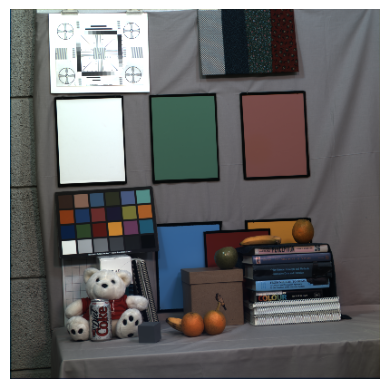

In [9]:
(lams, hpim) = data.importer.BearAndFruit_low_res()
l,h,w = hpim.shape
print(l,h,w)
vis.draw_hpim(hpim, draw=True, lams = lams, method='Gaussians')
sd = dim.SpectralDim()
sd.loadSpectralBasis('data/spectral_basis_data_400-10-700.npy')
metrics, hib, _ = qm.getQualityMetrics2() # hib stands for higher is better.

The grayscale image is the total limuniscence in that pixel.

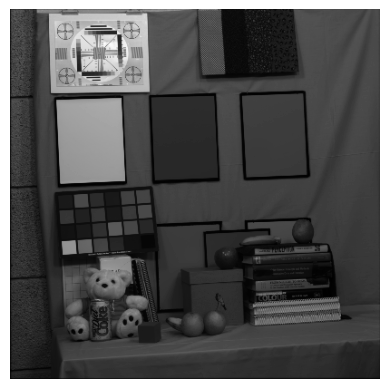

In [3]:
gray_img = np.sum(hpim, axis=0, keepdims=True)
plt.imshow(gray_img[0,:,:], cmap='gray')
plt.axis('off')
plt.show()

We need to determine how we are going to sample the hyperspectral scene. Below is an example on uniform sampling with a whisk broom scanner.

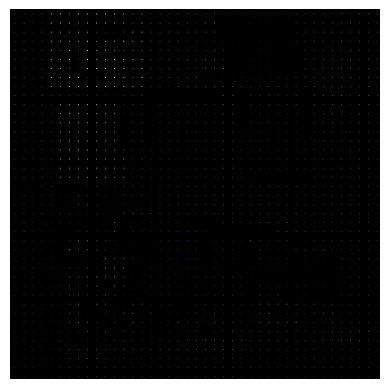

In [4]:
mask = init.get_uniform_sampling_pattern(h, w, 0.01)
spectral_clues = mask * hpim
_=vis.draw_hpim(spectral_clues, draw=True, lams = lams, method='1931')

Now we can initialize our colorization class with its inputs!

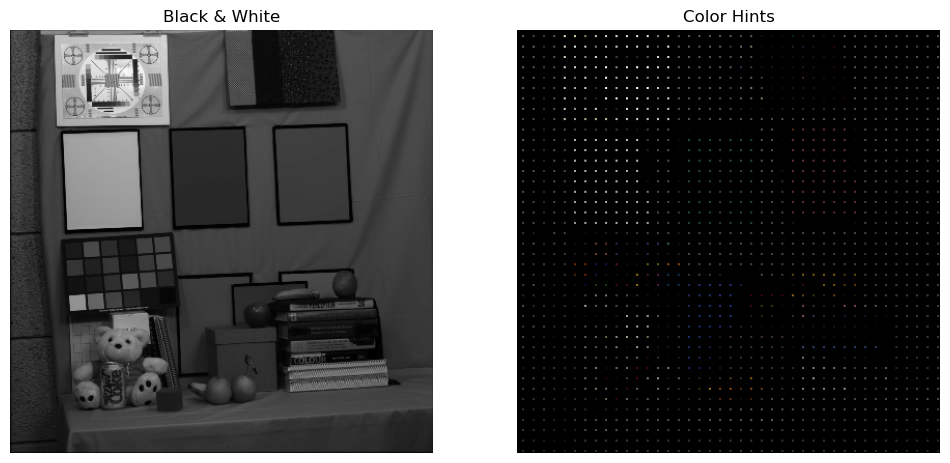

In [5]:
GClr = clr.GlobalColorizer(gray_img = gray_img, visual_clues=spectral_clues, draw_method = '1931', lams = lams)
# A visualization of current inputs:
GClr.plot_inputs(convolve=np.ones((2,2)))
# Convolve option is for increasing the size of spectral clues in the visualization. It does not modify the actual inputs. 

Now lets colorize!This takes around 1.5 seconds on my laptop.

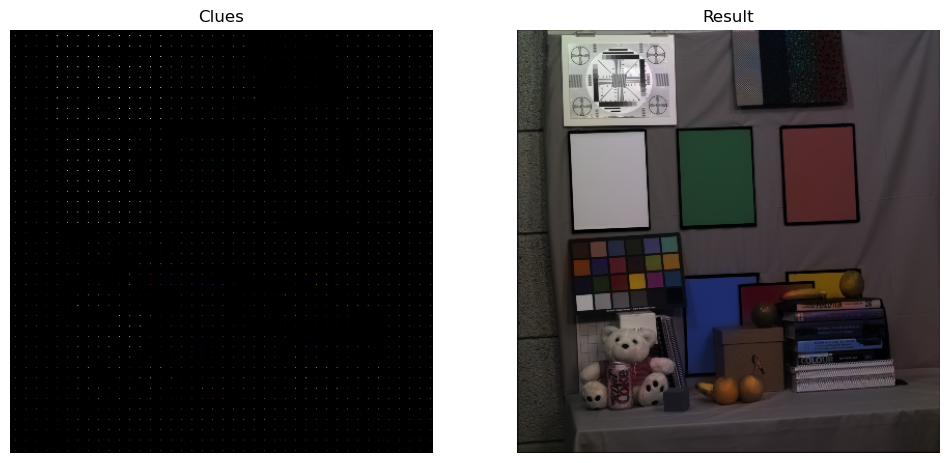

In [6]:
result = GClr.hyperColorize(draw_result = True)
# vis.clicker_visualization(lams, hpim, result,  name1='GT', name2='Result', draw= 2) # Collab does not support opencv windows. 
# Uncommoent the line above if you are running this notebook locally. It will open a window and you can click on the image to see the corresponding spectrum.

If we have noise in our image, colorizing in a lower dimensional space is beneficial. Our package can estimate the optimal dimensionality for colorization for you too! Now lets learn how to do it. 

12


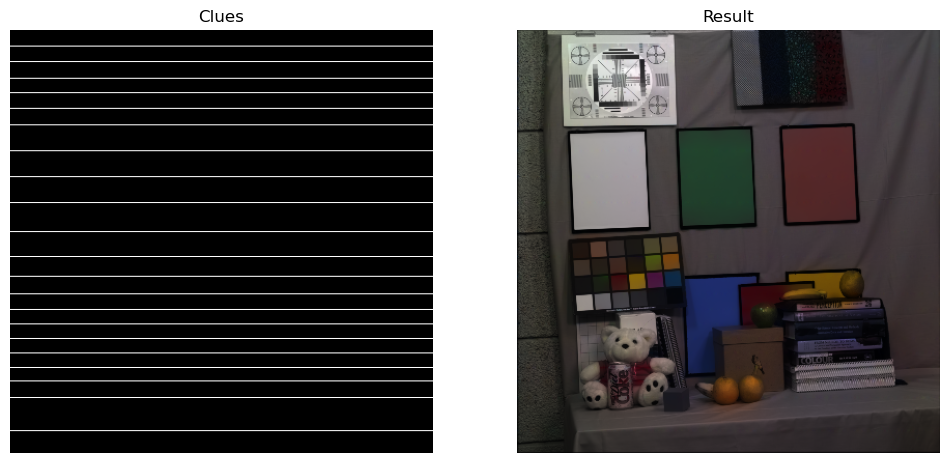

In [7]:
hpim_noised = noise.addPoissonNoise(hpim, 1e-4) # 1e-4 is the exposure time, lower values will create more noise.
hpim_noised = noise.addGaussianNoise(hpim_noised, 0, 0.01)
spectral_clues = hpim_noised * init.get_guided_pushbroom(gray_img, 0.05)
ideal_dimensionality = sd.intrinsicDimension(spectral_clues, method = 'two_features')
print(ideal_dimensionality)
hpim_ldim = sd.project(spectral_clues, ideal_dimensionality)
GClr = clr.GlobalColorizer(gray_img = gray_img, visual_clues=hpim_ldim, draw_method = '1931', lams = lams)
_=GClr.hyperColorize(draw_result = True, sd=sd)

Below we test different sampling algorithms.

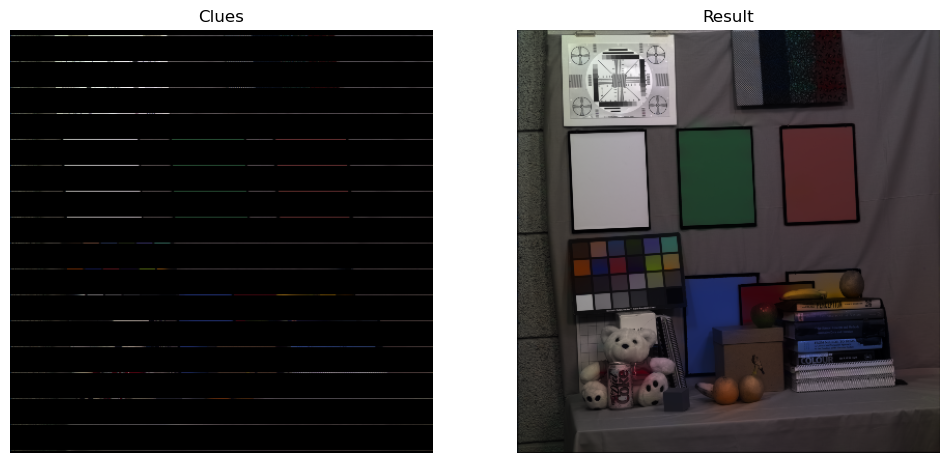

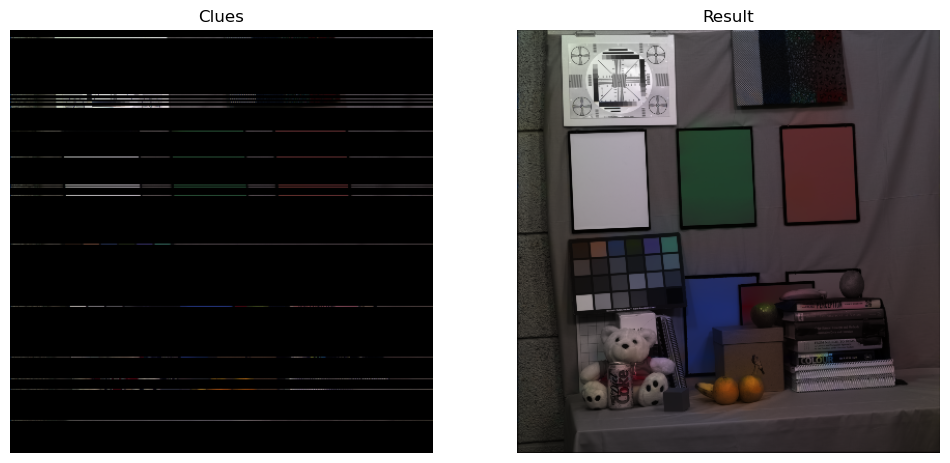

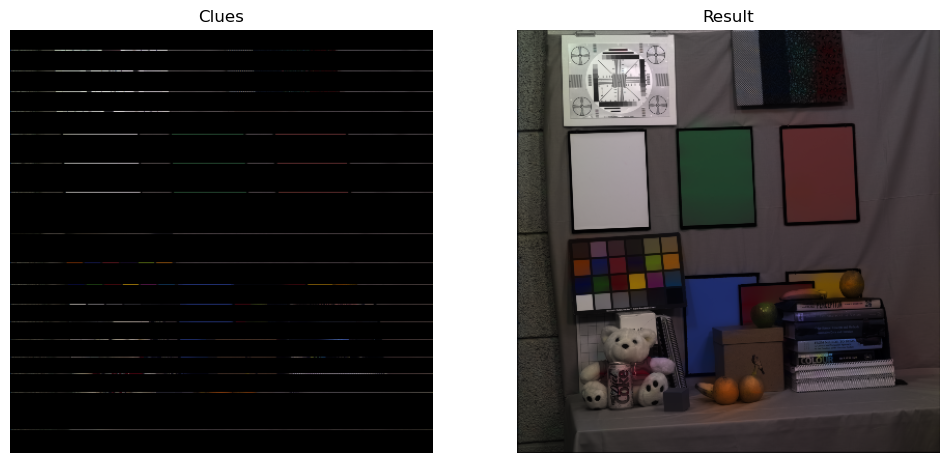

EMD:				Sample Count:
uni: 0.00707			6936
rnd: 0.00862			6936
gdd: 0.00651			6936


In [12]:
init.testPatternsPushbroom(GClr, hpim, gray_img, lams, 0.04, metrics, 'EMD', bin_count=64, optional_weight=0.8, draw_method='1931')

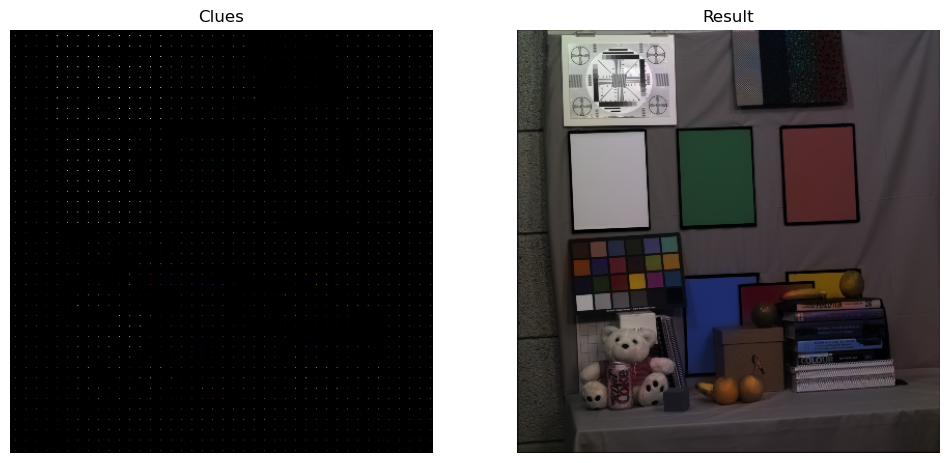

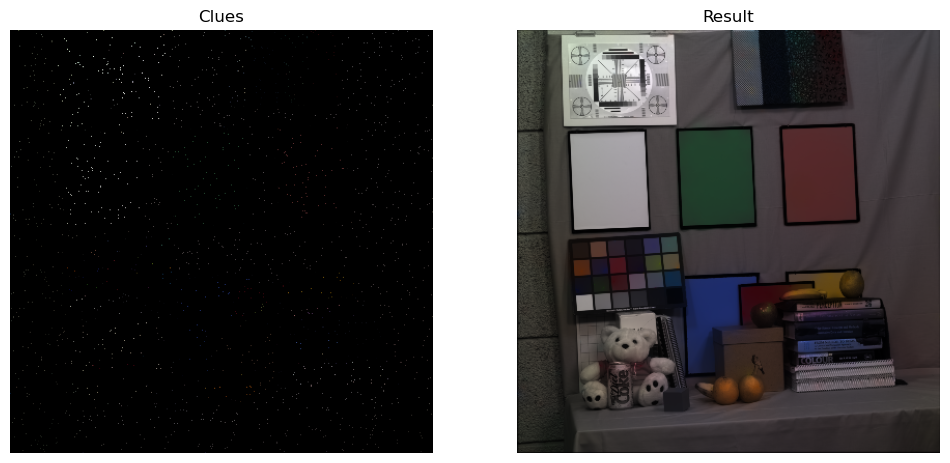

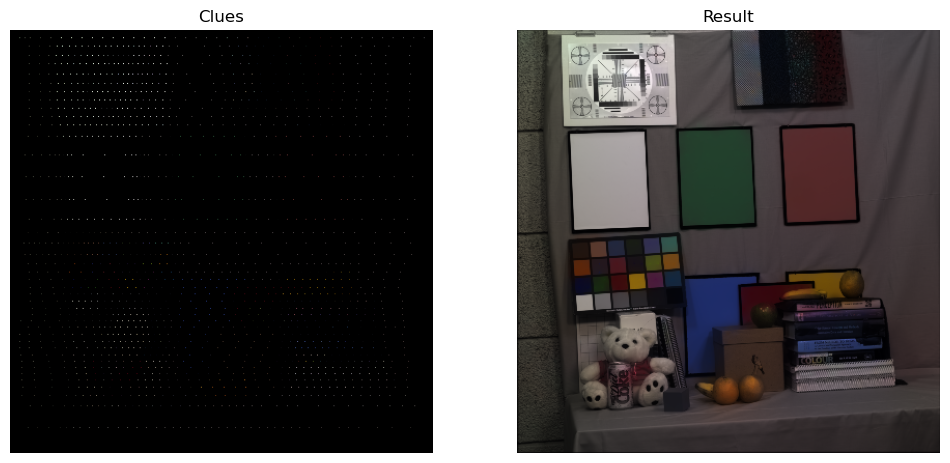

EMD:				Sample Count:
uni: 0.00667			1681
rnd: 0.00747			1681
gdd: 0.00662			1681


In [13]:
init.testPatternsWhiskbroom(GClr, hpim, gray_img, lams, 0.01, metrics, 'EMD', bin_count=16, optional_weight=1.0, draw_method='1931', save=False)